In [1]:
# ✅ Install required libraries (if needed)
# !pip install tensorflow scikit-learn opencv-python pillow matplotlib

import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
from glob import glob
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
# ✅ Step 1: Load images
img_dir = r"C:\Users\Asus\Desktop\PollenGrainClassification\archive (3)"
img_size = (128, 128)
image_paths = glob(os.path.join(img_dir, "*.jpg"))

images = []
labels = []

for path in image_paths:
    try:
        img = load_img(path, target_size=img_size)
        img_array = img_to_array(img) / 255.0
        images.append(img_array)

        fname = os.path.basename(path)
        class_name = fname.split("_")[0].split("(")[0].strip().lower()
        labels.append(class_name)

    except Exception as e:
        print(f"Error loading {path}: {e}")

print("✅ Total images:", len(images))
print("✅ Total labels:", len(labels))
print("📦 Classes found:", sorted(set(labels)))

✅ Total images: 790
✅ Total labels: 790
📦 Classes found: ['anadenanthera', 'arecaceae', 'arrabidaea', 'cecropia', 'chromolaena', 'combretum', 'croton', 'dipteryx', 'eucalipto', 'faramea', 'hyptis', 'mabea', 'matayba', 'mimosa', 'myrcia', 'protium', 'qualea', 'schinus', 'senegalia', 'serjania', 'syagrus', 'tridax', 'urochloa']


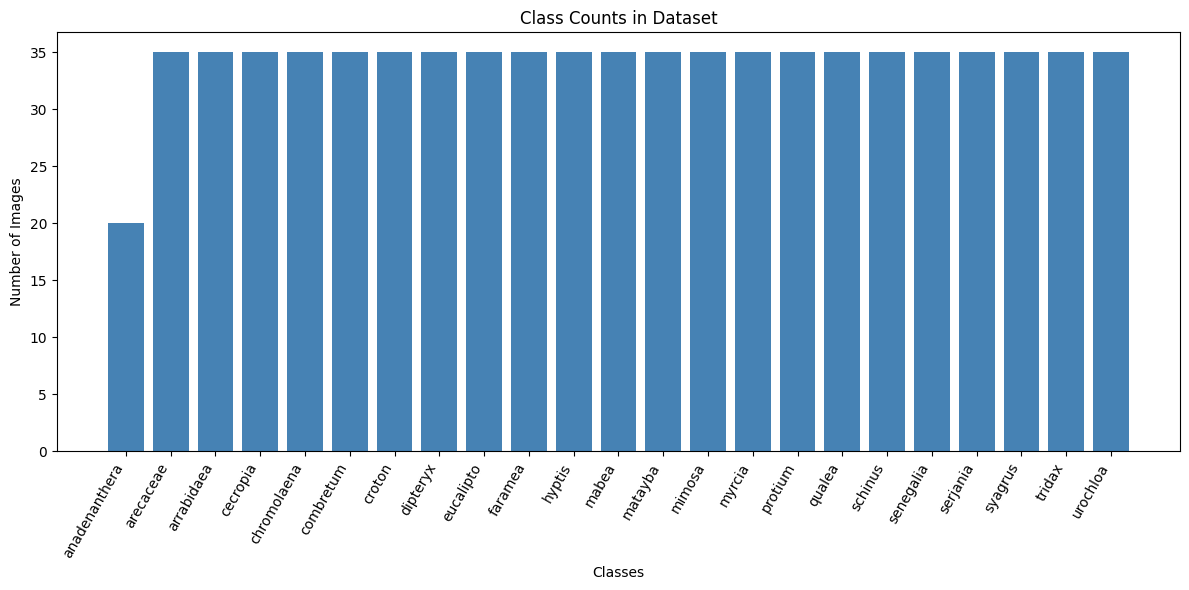

In [9]:
# ✅ Plot class distribution before filtering
import matplotlib.pyplot as plt
from collections import Counter

class_counts = Counter(labels)

# Ensure sorted order for consistent display
sorted_items = sorted(class_counts.items(), key=lambda x: x[0])
classes, counts = zip(*sorted_items)

plt.figure(figsize=(12, 6))
plt.bar(classes, counts, color='steelblue')
plt.title("Class Counts in Dataset")
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()


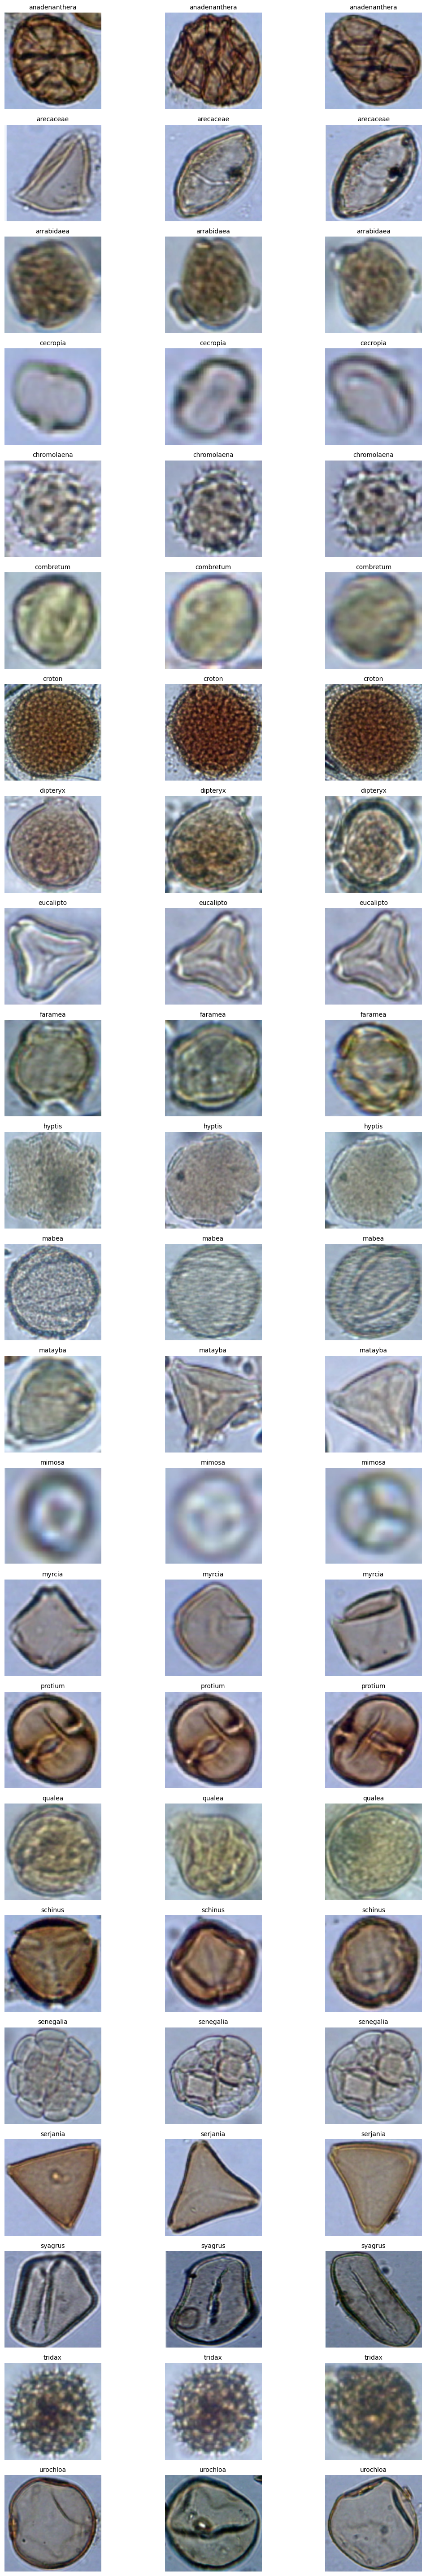

In [16]:
import os
import matplotlib.pyplot as plt
from glob import glob
from tensorflow.keras.preprocessing.image import load_img
from collections import defaultdict

# ✅ Directory where images are stored
img_dir = r"C:\Users\Asus\Desktop\PollenGrainClassification\archive (3)"
image_paths = glob(os.path.join(img_dir, "*.jpg"))

# ✅ Collect up to 3 images per class
class_images = defaultdict(list)
for path in image_paths:
    class_name = os.path.basename(path).split("_")[0].split("(")[0].strip().lower()
    if len(class_images[class_name]) < 3:
        class_images[class_name].append(path)

# ✅ Increase subplot and image size
num_classes = len(class_images)
plt.figure(figsize=(12, num_classes * 2.5))  # Increase height based on number of classes

i = 1
for class_name, paths in sorted(class_images.items()):
    for path in paths:
        img = load_img(path, target_size=(128, 128))  # Larger display resolution
        plt.subplot(num_classes, 3, i)
        plt.imshow(img)
        plt.title(class_name, fontsize=10)
        plt.axis("off")
        i += 1

plt.tight_layout()
plt.show()


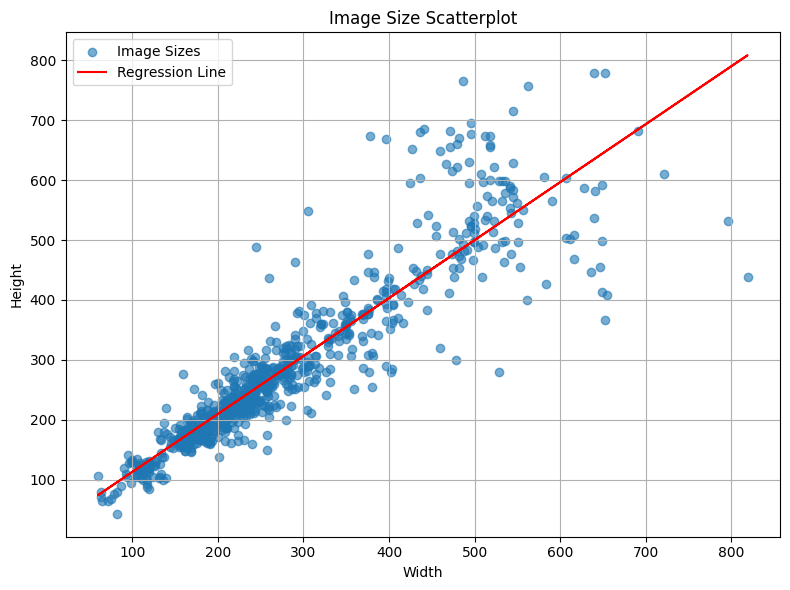

In [15]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
from glob import glob

# Path to your image folder
img_dir = r"C:\Users\Asus\Desktop\PollenGrainClassification\archive (3)"
image_paths = glob(os.path.join(img_dir, "*.jpg"))

# ✅ Collect width and height of all images
widths, heights = [], []

for path in image_paths:
    try:
        img = Image.open(path)
        width, height = img.size
        widths.append(width)
        heights.append(height)
        img.close()
    except Exception as e:
        print(f"Error processing {path}: {e}")
        continue

# ✅ Plot scatter
plt.figure(figsize=(8, 6))
plt.scatter(widths, heights, alpha=0.6, label='Image Sizes')
plt.xlabel("Width")
plt.ylabel("Height")
plt.title("Image Size Scatterplot")

# ✅ Fit and plot regression line
if widths and heights:
    m, b = np.polyfit(widths, heights, 1)
    regression_line = np.array(widths) * m + b
    plt.plot(widths, regression_line, color='red', label='Regression Line')

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [3]:
# ✅ Step 2: Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(labels)
y_categorical = to_categorical(y_encoded)

# ✅ Save class order
with open("label_classes.pkl", "wb") as f:
    pickle.dump(le.classes_, f)

In [4]:
# ✅ Step 3: Filter classes with < 2 samples
label_counts = Counter(np.argmax(y_categorical, axis=1))
valid_indices = [i for i, label in enumerate(np.argmax(y_categorical, axis=1)) if label_counts[label] >= 2]

X = np.array(images)[valid_indices]
y = y_categorical[valid_indices]

In [5]:

# ✅ Step 4: Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print("✅ Training shape:", X_train.shape)
print("✅ Validation shape:", X_val.shape)

✅ Training shape: (632, 128, 128, 3)
✅ Validation shape: (158, 128, 128, 3)


In [6]:
# ✅ Step 4: Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print("✅ Training shape:", X_train.shape)
print("✅ Validation shape:", X_val.shape)

# ✅ Step 5: Data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)

✅ Training shape: (632, 128, 128, 3)
✅ Validation shape: (158, 128, 128, 3)


In [7]:
# ✅ Step 6: Build model
model = Sequential([
    Input(shape=(128, 128, 3)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dense(y.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 23)             │         5,911 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,488,023 (32.38 MB)

 Trainable params: 8,488,023 (32.38 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# ✅ Step 7: Train model
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint("best_model.keras", save_best_only=True)
]

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=8),
    steps_per_epoch=len(X_train) // 8,
    validation_data=(X_val, y_val),
    epochs=50,
    callbacks=callbacks,
    verbose=1
)

c:\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 15s 159ms/step - accuracy: 0.0517 - loss: 3.1884 - val_accuracy: 0.1013 - val_loss: 2.6621
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 154ms/step - accuracy: 0.1292 - loss: 2.5945 - val_accuracy: 0.2278 - val_loss: 2.4390
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 0.1722 - loss: 2.4222 - val_accuracy: 0.2975 - val_loss: 2.3403
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 0.2822 - loss: 2.1545 - val_accuracy: 0.3481 - val_loss: 2.1026
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - accuracy: 0.2630 - loss: 2.0347 - val_accuracy: 0.2785 - val_loss: 2.1194
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 157ms/step - accuracy: 0.3768 - loss: 1.9007 - val_accuracy: 0.3861 - val_loss: 1.9466
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 155ms/step - accuracy: 0.3437 - loss: 1.9793 - val_accuracy: 0.3861 - val_loss: 1.9186
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 13s 159ms/step - accuracy: 0.4183 - loss: 1.7568 - val_accu

In [10]:
# ✅ Step 8: Evaluate model
score = model.evaluate(X_val, y_val, verbose=0)
print(f"✅ Final Validation Accuracy: {score[1]:.2%}")


✅ Final Validation Accuracy: 80.38%


In [11]:
# ✅ Step 9: Prediction on new image
def predict_image(path):
    img = load_img(path, target_size=(128, 128))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    model = load_model("best_model.keras")
    with open("label_classes.pkl", "rb") as f:
        class_names = pickle.load(f)

    y_pred = model.predict(img_array)
    class_idx = np.argmax(y_pred)
    print("Predicted Class:", class_names[class_idx])
    return class_names[class_idx]

# ✅ Optional Test
test_image = r"C:\Users\Asus\Desktop\PollenGrainClassification\archive (3)\qualea_10.jpg"
predict_image(test_image)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
Predicted Class: qualea


np.str_('qualea')

In [12]:
test_image = r"C:\Users\Asus\Desktop\PollenGrainClassification\archive (3)\anadenanthera_18.jpg"
predict_image(test_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
Predicted Class: anadenanthera


np.str_('anadenanthera')

In [13]:
test_image = r"C:\Users\Asus\Desktop\PollenGrainClassification\archive (3)\cecropia_24.jpg"
predict_image(test_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
Predicted Class: cecropia


np.str_('cecropia')